In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
import cv2
from PIL import Image
from glob import glob
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import gradio


%matplotlib inline

ModuleNotFoundError: No module named 'gradio'

In [98]:
pip install gradio

ERROR: Could not find a version that satisfies the requirement gradio (from versions: none)
ERROR: No matching distribution found for gradio
Note: you may need to restart the kernel to use updated packages.


# **Getting the dataset**

In [4]:
main = '/kaggle/input/chest-xray-pneumonia/chest_xray'

normal_train = glob(os.path.join(main,"train","NORMAL","*jpeg"))
pneumonia_train = glob(os.path.join(main,"train","PNEUMONIA","*jpeg"))

normal_test = glob(os.path.join(main,"test","NORMAL","*jpeg"))
pneumonia_test = glob(os.path.join(main,"test","PNEUMONIA","*jpeg"))

normal_val = glob(os.path.join(main,"val","NORMAL","*jpeg"))
pneumonia_val = glob(os.path.join(main,"val","PNEUMONIA","*jpeg"))

# **Creating DataFrame**

In [5]:
df_train = pd.DataFrame({
    'Predicted':['Not Pneumonia'] * len(normal_train) + ['Pneumonia'] * len(pneumonia_train),
    'Image': normal_train + pneumonia_train
})

df_test = pd.DataFrame({
    'Predicted':['Not Pneumonia'] * len(normal_test) + ['Pneumonia'] * len(pneumonia_test),
    'Image': normal_test + pneumonia_test
})

df_val = pd.DataFrame({
    'Predicted':['Not Pneumonia'] * len(normal_val) + ['Pneumonia'] * len(pneumonia_val),
    'Image': normal_val + pneumonia_val
})

In [6]:
df_train.head()

,Predicted,Image
0,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
1,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
2,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
3,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
4,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...


In [7]:
df_test.tail()

,Predicted,Image
619,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
620,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
621,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
622,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
623,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...


In [8]:
df_val.head()

,Predicted,Image
0,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
1,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
2,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
3,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...
4,Not Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/...


In [9]:
#Concatinating validation data with the training data 
df_train = pd.concat([df_train,df_val],axis = 0)

#Resetting Index
df_train=df_train.reset_index(drop=True)

# **Exploratory Data Analysis**

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Predicted  5232 non-null   object
 1   Image      5232 non-null   object
dtypes: object(2)
memory usage: 81.9+ KB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Predicted  624 non-null    object
 1   Image      624 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


In [12]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Predicted  16 non-null     object
 1   Image      16 non-null     object
dtypes: object(2)
memory usage: 384.0+ bytes


In [13]:
#Checking for null values on training dataset
df_train.isnull().sum()

Predicted    0
Image        0
dtype: int64

In [14]:
#Checking for null values on testing dataset 
df_test.isnull().sum()

Predicted    0
Image        0
dtype: int64

In [15]:
#Checking for null values on validation dataset
df_val.isnull().sum()

Predicted    0
Image        0
dtype: int64

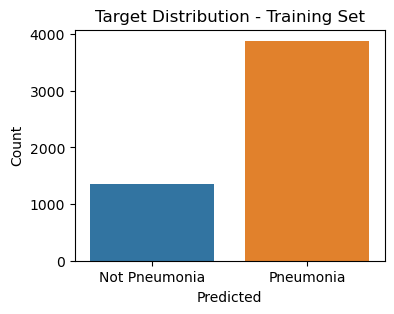

In [16]:
#Ploting Target Distribution on training dataset
plt.figure(figsize=(4,3))
sns.countplot(data=df_train, x='Predicted')
plt.title('Target Distribution - Training Set')
plt.xlabel('Predicted')
plt.ylabel('Count')
plt.show()

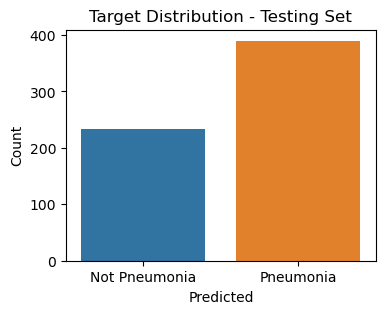

In [17]:
#Ploting Target Distribution on testing dataset
plt.figure(figsize=(4,3))
sns.countplot(data=df_test, x='Predicted')
plt.title('Target Distribution - Testing Set')
plt.xlabel('Predicted')
plt.ylabel('Count')
plt.show()

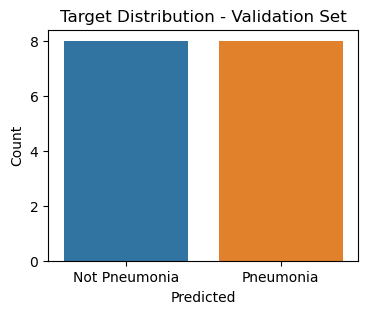

In [18]:
#Ploting Target Distribution on testing dataset
plt.figure(figsize=(4,3))
sns.countplot(data=df_val, x='Predicted')
plt.title('Target Distribution - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Predicted', ylabel='Count'>

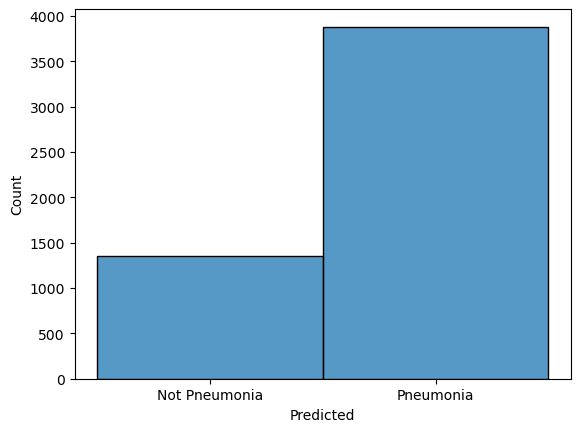

In [19]:
#Using Histplot to count total number of pneumonia cases on training dataset
sns.histplot(data = df_train['Predicted'])

<Axes: xlabel='Predicted', ylabel='Count'>

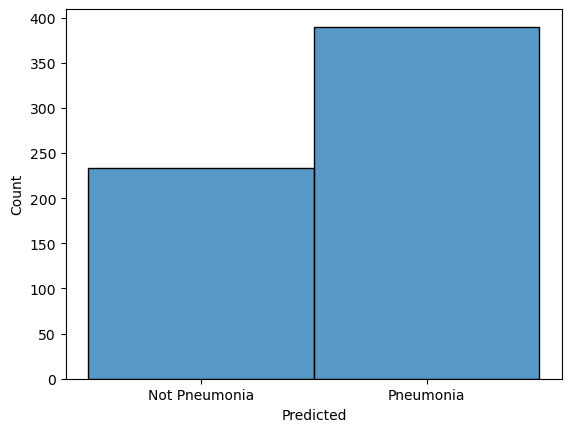

In [20]:
#Using Histplot to count total number of pneumonia cases on testing dataset
sns.histplot(data = df_test['Predicted'])

<Axes: xlabel='Predicted', ylabel='Count'>

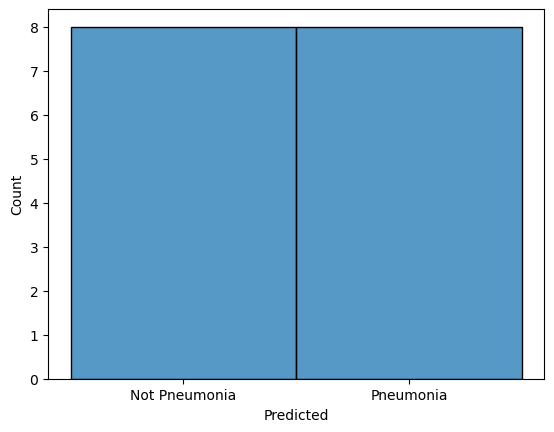

In [21]:
#Using Histplot to count total number of pneumonia cases on validation dataset
sns.histplot(data = df_val['Predicted'])

# **Data Preprocessing**
**Getting, Training and Testing Dataset**

In [22]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [25]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/tmp/ipykernel_32/771166761.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



**Splitting x and y labels of training, testing and validation Dataset**

In [28]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [29]:
positives=[]
negatives=[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else:
        negatives.append(x_train[i])

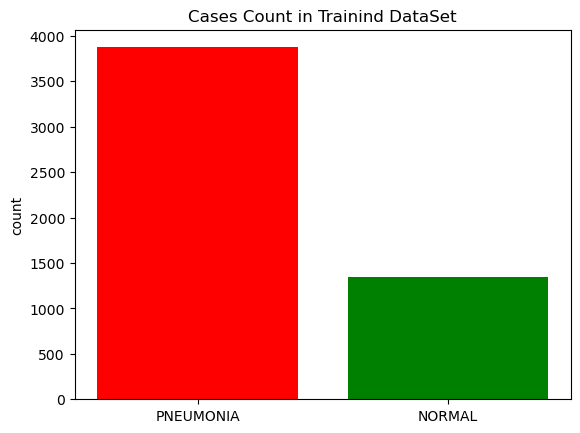

In [32]:
#Count Cases of training dataset
plt.bar(labels,[len(negatives),len(positives)],color = ['red','green'])
plt.title('Cases Count in Trainind DataSet')
plt.ylabel('count')
plt.show()

**The Data Seems Unbalanced we will use data augmentation to increase the number of training examples**

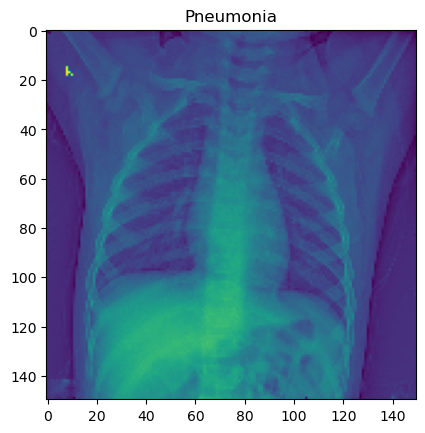

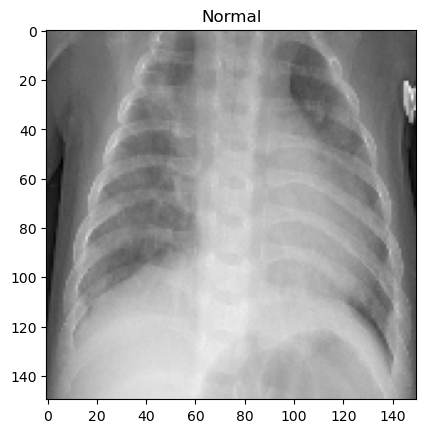

In [36]:
#Images for Normal And Pneumonia Chest X-Rays
plt.imshow(positives[0]) 
plt.title("Pneumonia") 
plt.show()

plt.imshow(negatives[4], cmap="gray") 
plt.title("Normal") 
plt.show()

**Perform Grayscale to normalization to reduce the effect of illumination(the images shown above) difference**

In [34]:
#Normalization Of Data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) /255

In [38]:
#Resize Data For Deep Learning
x_train = x_train.reshape(-1, img_size , img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [39]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1) 
y_val = y_val.reshape(-1,1)

# **Data Augmentation**

**In order to avoid overfitting problem we alter the table data with small transformations to reproduce the variations**

In [96]:
datagen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False, 
    zca_whitening=False,
    rotation_range = 30, #rotates images within the given range
    zoom_range = 0.2, #zooms the image
    width_shift_range=0.1, #shifts images horizontally
    height_shift_range=0.1, #shifts image vertically
    horizontal_flip = True, #flips images randomly
    vertical_flip=False)

datagen.fit(x_train)

In [47]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1))) 
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout (0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3), strides = 1, padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))

model.add(Conv2D(128 , (3,3), strides = 1, padding = 'same' , activation = 'relu')) 
model.add(Dropout (0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' ,  activation = 'relu')) 
model.add(Dropout (0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 120 , activation = 'relu'))
model.add(Dropout (0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_14 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_9 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_15 (Bat  (None, 75, 75, 64)      

In [48]:
#Model Summary
model.compile(optimizer = "rmsprop" , 
              loss =  'binary_crossentropy' ,
              metrics = ['accuracy'])

In [50]:
#Reduce Learning Rate 
learning = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [51]:
#Fit the model
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs =10 ,
                    validation_data = datagen.flow(x_val, y_val), 
                    callbacks = learning)

Epoch 1/10
163/163 [==============================] - 216s 1s/step - loss: 0.5963 - accuracy: 0.8276 - val_loss: 19.9231 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 213s 1s/step - loss: 0.2691 - accuracy: 0.8984 - val_loss: 20.8173 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9156
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 214s 1s/step - loss: 0.2166 - accuracy: 0.9156 - val_loss: 29.6382 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 210s 1s/step - loss: 0.1429 - accuracy: 0.9480 - val_loss: 17.5301 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9519
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==========================

In [52]:
#Saving the model
model.save_weights('kaggle/saved_model_ai/pneumoniadetection')

**Evaluation Metrics**

In [54]:
print("Loss of the model is -" , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is-" , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 6s 289ms/step - loss: 0.2797 - accuracy: 0.9006
Loss of the model is - 0.2796816825866699
20/20 [==============================] - 6s 291ms/step - loss: 0.2797 - accuracy: 0.9006
Accuracy of the model is- 90.06410241127014 %


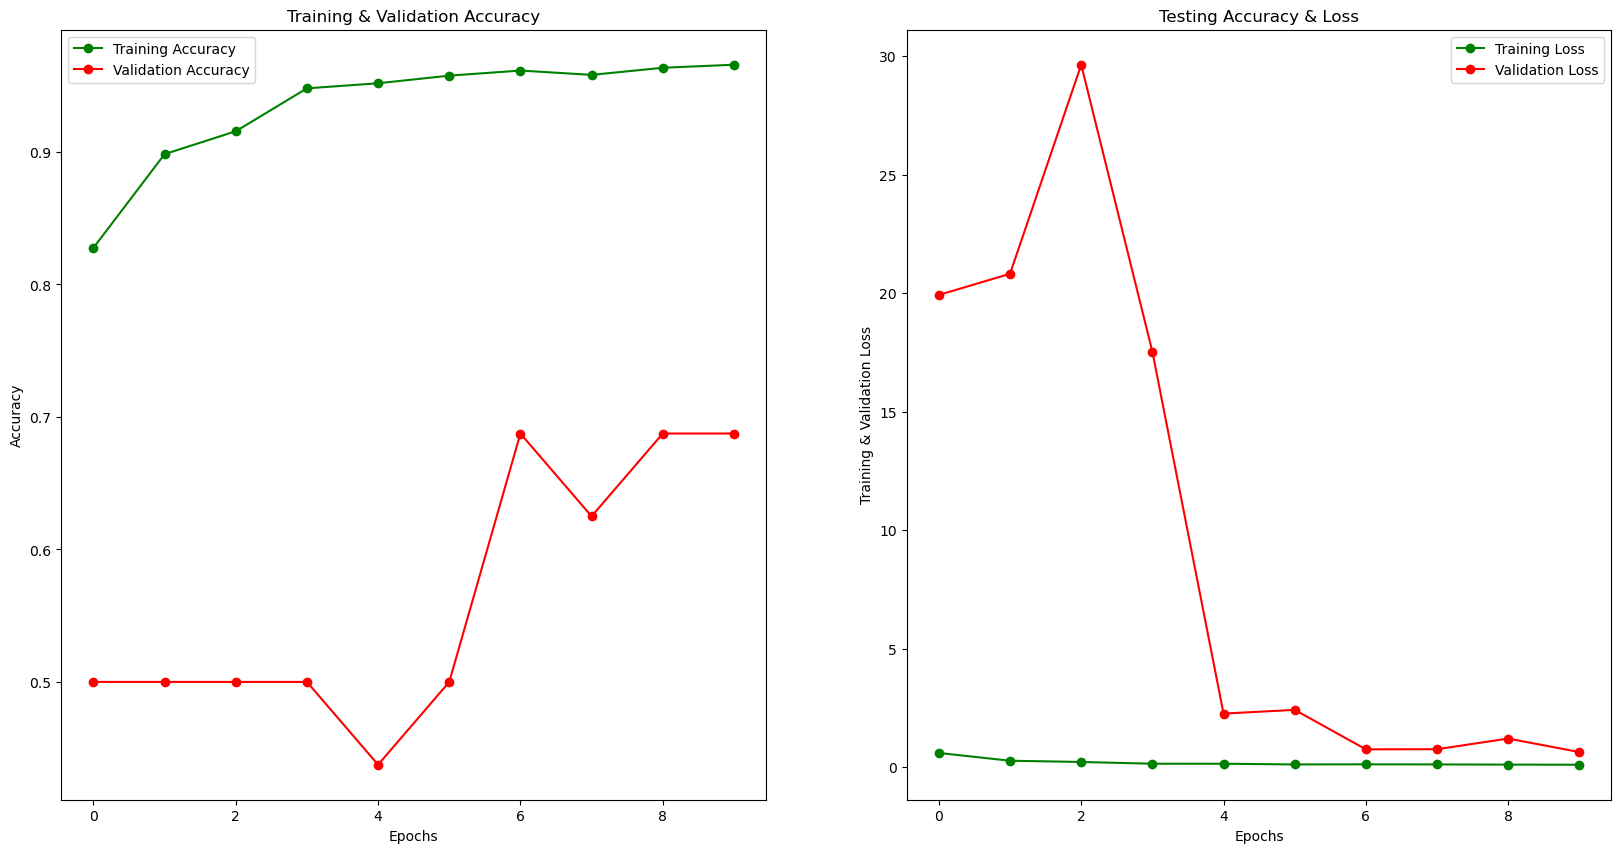

In [57]:
#Visualize the accuracy vs loss
epochs = list(range(10))
fig, ax = plt.subplots(1,2)
train_acc = history.history ['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs, val_acc , 'ro-' , label = 'Validation Accuracy') 
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs") 
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss, 'r-o' , label = 'Validation Loss') 
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()


In [58]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 6s 293ms/step


In [60]:
print(classification_report(y_test,
                            predictions,
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.89      0.92       390
   Normal (Class 1)       0.84      0.91      0.87       234

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.90       624
       weighted avg       0.90      0.90      0.90       624



**Confusion matrix**

In [63]:
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index = ['0','1'] , columns = ['0', '1'])
cm

,0,1
0,349,41
1,21,213


In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

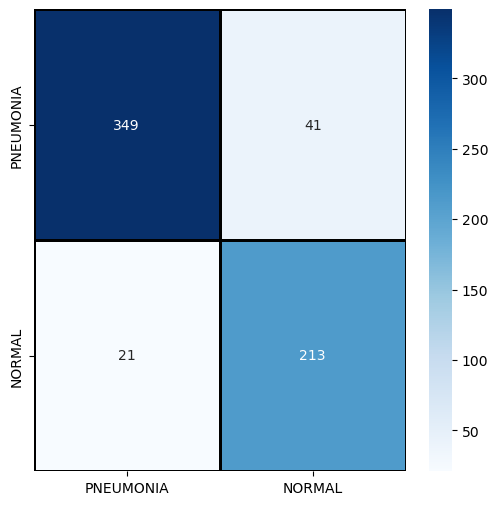

In [77]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
            annot = True, fmt='',xticklabels = labels,yticklabels = labels)